In [1]:
import numpy as np
import sys 
sys.path.append(r'../Python Script/')

from sympy import symbols, simplify, derive_by_array
from scipy.integrate import solve_ivp
from xLSINDy import *
from sympy.physics.mechanics import *
from sympy import *
import sympy
import torch
import HLsearch as HL
import matplotlib.pyplot as plt

In [2]:
L1, L2 = 1, 1
m1, m2 = 1, 1
k1, k2 = 0.5, 0.5
g = 9.8

In [3]:
states_dim = 4
states = ()
states_dot = ()
for i in range(states_dim):
    if(i<states_dim//2):
        states = states + (symbols('x{}'.format(i)),)
        states_dot = states_dot + (symbols('x{}_t'.format(i)),)
    else:
        states = states + (symbols('x{}_t'.format(i-states_dim//2)),)
        states_dot = states_dot + (symbols('x{}_tt'.format(i-states_dim//2)),)
print('states are:',states)
print('states derivatives are: ', states_dot)

#Turn from sympy to str
states_sym = states
states_dot_sym = states_dot
states = list(str(descr) for descr in states)
states_dot = list(str(descr) for descr in states_dot)

states are: (x0, x1, x0_t, x1_t)
states derivatives are:  (x0_t, x1_t, x0_tt, x1_tt)


In [4]:
#For friction force
x0 = Symbol(states[0], real=True)
x1 = Symbol(states[1], real=True)
x0_t = Symbol(states[2],real=True)
x1_t = Symbol(states[3],real=True)
q = sympy.Array([x0, x1])
qdot = sympy.Array([x0_t, x1_t])

#True Rayleigh Dissipation function
R = 0.5*k1*x0_t**2 + 0.5*k2*(x1_t - x0_t)**2 #+ k1*Abs(x0_t) + k2*Abs(x1_t - x0_t)

#friction force
f_forcing = sympy.Matrix(derive_by_array(R, qdot)) 

In [5]:
#for lagrangian
x0 = dynamicsymbols(states[0], real=True)
x1 = dynamicsymbols(states[1], real=True)
x0_t = dynamicsymbols(states[0],1, real=True)
x1_t = dynamicsymbols(states[1],1, real=True)
tau0 = symbols('tau0')
tau1 = symbols('tau1')

#True Lagrangian
L = 0.5*(m1+m2)*L1**2*x0_t**2 + 0.5*m2*L2**2*x1_t**2 + m2*L2**2*x0_t*x1_t*cos(x0)*cos(x1) + m2*L2**2*x0_t*x1_t*sin(x0)*sin(x1) + (m1+m2)*g*L1*cos(x0) + m2*g*L2*cos(x1)

# Lagrange's method
LM = LagrangesMethod(L, [x0,x1])
LM.form_lagranges_equations()
i_forcing = LM.forcing #internal forcing and gravity
e_forcing = sympy.Matrix([tau0-tau1, tau1]) #external generalized force

In [6]:
# Substituting dynamic symbols

i_forcing = i_forcing.subs(x0_t, states_sym[2])
i_forcing = i_forcing.subs(x1_t, states_sym[3])
i_forcing = i_forcing.subs(x0, states_sym[0])
i_forcing = i_forcing.subs(x1, states_sym[1])

M = LM.mass_matrix
M = M.subs(x0, states_sym[0])
M = M.subs(x1, states_sym[1])

In [7]:
# Generating equation of motion
t_forcing = i_forcing + e_forcing - f_forcing
eom = M.inv()*sympy.Matrix(t_forcing)

In [8]:
''' Please copy the string shown to the definition of equation in the function of double pendulum'''
for i in range(len(eom)):
    print('Equation ' + str(i) +': ' + str(eom[i]))
    print('\n')

Equation 0: 1.0*(2.0*sin(x0)*sin(x1) + 2.0*cos(x0)*cos(x1))*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) + 0.5*x0_t - 0.5*x1_t - 9.8*sin(x1))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0) - 2.0*(tau0 - tau1 - 1.0*x0_t - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) + 0.5*x1_t - 19.6*sin(x0))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0)


Equation 1: 1.0*(1.0*sin(x0)*sin(x1) + 1.0*cos(x0)*cos(x1))*(tau0 - tau1 - 1.0*x0_t - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) + 0.5*x1_t - 19.6*sin(x0))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0) - 2.0*(tau1 + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) + 0.5*x0_t - 0.5*x1_t - 9.8*sin(x1))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0)




In [9]:
import time

def generate_data(func, time, init_values):
    sol = solve_ivp(func,[time[0],time[-1]],init_values,t_eval=time, method='RK45',rtol=1e-10,atol=1e-10)
    return sol.y.T, np.array([func(0,sol.y.T[i,:]) for i in range(sol.y.T.shape[0])],dtype=np.float64)


def doublePendulum(t,y):
    from numpy import sin, cos, sign
    x0,x1,x0_t,x1_t = y
    tau0, tau1 = 0, 0
    x0_tt = 1.0*(2.0*sin(x0)*sin(x1) + 2.0*cos(x0)*cos(x1))*(tau1 + 0.5*x0_t + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) - 0.5*x1_t - 9.8*sin(x1))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0) - 2.0*(tau0 - tau1 - 1.0*x0_t - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) + 0.5*x1_t - 19.6*sin(x0))/(2.0*sin(x0)**2*sin(x1)**2 + 4.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 2.0*cos(x0)**2*cos(x1)**2 - 4.0)
    x1_tt =  1.0*(1.0*sin(x0)*sin(x1) + 1.0*cos(x0)*cos(x1))*(tau0 - tau1 - 1.0*x0_t - x1_t**2*sin(x0)*cos(x1) + x1_t**2*sin(x1)*cos(x0) + 0.5*x1_t - 19.6*sin(x0))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0) - 2.0*(tau1 + 0.5*x0_t + x0_t**2*sin(x0)*cos(x1) - x0_t**2*sin(x1)*cos(x0) - 0.5*x1_t - 9.8*sin(x1))/(1.0*sin(x0)**2*sin(x1)**2 + 2.0*sin(x0)*sin(x1)*cos(x0)*cos(x1) + 1.0*cos(x0)**2*cos(x1)**2 - 2.0)
    return x0_t,x1_t,x0_tt,x1_tt



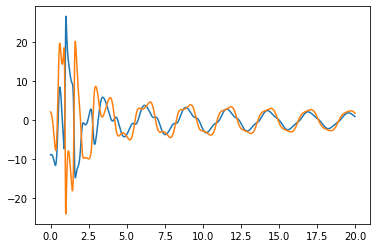

In [24]:
#Test equation
t = np.arange(0,20,0.01)
theta1 = np.random.uniform(-np.pi, np.pi)
thetadot = np.random.uniform(0,0)
theta2 = np.random.uniform(-np.pi, np.pi)
        
y0=np.array([theta1, theta2, thetadot, thetadot])
x,xdot = generate_data(doublePendulum,t,y0)

plt.plot(t,xdot[:,2])
plt.plot(t,xdot[:,3])
plt.show()

In [ ]:
#Saving Directory
rootdir = "../Double Pendulum/Data/"

num_sample = 100
create_data = False
training = True
save = False
noiselevel = 0

In [ ]:
if(create_data):
    print("Creating Data")
    num_sample = 100
    X, Xdot = [], []
    for i in range(num_sample):
        t = np.arange(0,5,0.01)
        theta1 = np.random.uniform(-np.pi, np.pi)
        thetadot = np.random.uniform(0,0)
        theta2 = np.random.uniform(-np.pi, np.pi)
        
        y0=np.array([theta1, theta2, thetadot, thetadot])
        x,xdot = generate_data(doublePendulum,t,y0)
        X.append(x)
        Xdot.append(xdot)
    X = np.vstack(X)
    Xdot = np.vstack(Xdot)
    if(save==True):
        np.save(rootdir + "X.npy", X)
        np.save(rootdir + "Xdot.npy",Xdot)
else:
    X = np.load(rootdir + "X.npy")
    Xdot = np.load(rootdir + "Xdot.npy")

In [ ]:
#adding noise
mu, sigma = 0, noiselevel
noise = np.random.normal(mu, sigma, X.shape[0])
for i in range(X.shape[1]):
    X[:,i] = X[:,i]+noise
    Xdot[:,i] = Xdot[:,i]+noise

In [ ]:
states_dim = 4
states = ()
states_dot = ()
for i in range(states_dim):
    if(i<states_dim//2):
        states = states + (symbols('x{}'.format(i)),)
        states_dot = states_dot + (symbols('x{}_t'.format(i)),)
    else:
        states = states + (symbols('x{}_t'.format(i-states_dim//2)),)
        states_dot = states_dot + (symbols('x{}_tt'.format(i-states_dim//2)),)
print('states are:',states)
print('states derivatives are: ', states_dot)

In [ ]:
#Turn from sympy to str
states_sym = states
states_dot_sym = states_dot
states = list(str(descr) for descr in states)
states_dot = list(str(descr) for descr in states_dot)

In [ ]:
#build function expression for the library in str
exprdummy = HL.buildFunctionExpressions(1,states_dim,states,use_sine=True)
polynom = exprdummy[2:4]
trig = exprdummy[4:]
polynom = HL.buildFunctionExpressions(2,len(polynom),polynom)
trig = HL.buildFunctionExpressions(2, len(trig),trig)
product = []
for p in polynom:
    for t in trig:
        product.append(p + '*' + t)
expr = polynom + trig + product

In [ ]:
#Creating library tensor
Zeta, Eta, Delta = LagrangianLibraryTensor(X,Xdot,expr,states,states_dot, scaling=True)

In [ ]:
## separating known and unknown terms ##
expr = np.array(expr)
i1 = np.where(expr == 'x0_t**2')[0]

## Garbage terms ##

'''
Explanation :
x0_t, x1_t terms are not needed and will always satisfy EL's equation.
Since x0_t, x1_t are garbages, we want to avoid (x0_t*sin()**2 + x0_t*cos()**2), thus we remove
one of them, either  x0_t*sin()**2 or x0_t*cos()**2. 
Since the known term is x0_t**2, we also want to avoid the solution of (x0_t**2*sin()**2 + x0_t**2*cos()**2),
so we remove either one of x0_t**2*sin()**2 or x0_t**2*cos()**2.
'''

i2 = np.where(expr == 'x0_t**2*cos(x0)**2')[0]
i3 = np.where(expr == 'x0_t**2*cos(x1)**2')[0]
i7 = np.where(expr == 'x1_t*cos(x0)**2')[0]
i8 = np.where(expr == 'x1_t*cos(x1)**2')[0]
i9 = np.where(expr == 'x1_t')[0]
i10 = np.where(expr == 'x0_t*cos(x0)**2')[0]
i11 = np.where(expr == 'x0_t*cos(x1)**2')[0]
i12 = np.where(expr == 'x0_t')[0]
i13 = np.where(expr == 'cos(x0)**2')[0]
i14 = np.where(expr == 'cos(x1)**2')[0]

#Deleting unused terms 
idx = np.arange(0,len(expr))
idx = np.delete(idx,[i1,i2,i3,i7,i8,i9,i10,i11,i12,i13,i14])
known_expr = expr[i1].tolist()
expr = np.delete(expr,[i1,i2,i3,i7,i8,i9,i10,i11,i12,i13,i14])

#non-penalty index from prev knowledge
i4 = np.where(expr == 'x1_t**2')[0][0]
i5 = np.where(expr == 'cos(x0)')[0][0]
i6 = np.where(expr == 'cos(x1)')[0][0]
nonpenaltyidx = [i4, i5, i6]

expr = expr.tolist()

Zeta_ = Zeta[:,:,i1,:].clone().detach()
Eta_ = Eta[:,:,i1,:].clone().detach()
Delta_ = Delta[:,i1,:].clone().detach()

Zeta = Zeta[:,:,idx,:]
Eta = Eta[:,:,idx,:]
Delta = Delta[:,idx,:]

In [ ]:
#Moving to Cuda
device = 'cuda:0'

Zeta = Zeta.to(device)
Eta = Eta.to(device)
Delta = Delta.to(device)

Zeta_ = Zeta_.to(device)
Eta_ = Eta_.to(device)
Delta_ = Delta_.to(device)

In [ ]:
xi_L = torch.ones(len(expr), device=device).data.uniform_(-20,20)
prevxi_L = xi_L.clone().detach()
c = torch.ones(len(known_expr), device=device)

In [ ]:
def loss(pred, targ):
    loss = torch.mean((pred - targ)**2) 
    return loss 

In [ ]:
def clip(w, alpha):
    clipped = torch.minimum(w,alpha)
    clipped = torch.maximum(clipped,-alpha)
    return clipped

def proxL1norm(w_hat, alpha, nonpenaltyidx):
    if(torch.is_tensor(alpha)==False):
        alpha = torch.tensor(alpha)
    w = w_hat - clip(w_hat,alpha)
    for idx in nonpenaltyidx:
        w[idx] = w_hat[idx]
    return w

In [ ]:
def training_loop(c,coef, prevcoef, RHS, LHS, xdot, bs, lr, lam, momentum=True):
    loss_list = []
    tl = xdot.shape[0]
    n = xdot.shape[1]

    Zeta_, Eta_, Delta_ = LHS
    Zeta, Eta, Delta = RHS

    if(torch.is_tensor(xdot)==False):
        xdot = torch.from_numpy(xdot).to(device).float()
    
    v = coef.clone().detach().requires_grad_(True)
    prev = v
    
    for i in range(tl//bs):
                
        #computing acceleration with momentum
        if(momentum==True):
            vhat = (v + ((i-1)/(i+2))*(v - prev)).clone().detach().requires_grad_(True)
        else:
            vhat = v.requires_grad_(True).clone().detach().requires_grad_(True)
   
        prev = v

        #Computing loss
        zeta = Zeta[:,:,:,i*bs:(i+1)*bs]
        eta = Eta[:,:,:,i*bs:(i+1)*bs]
        delta = Delta[:,:,i*bs:(i+1)*bs]

        zeta_ = Zeta_[:,:,:,i*bs:(i+1)*bs]
        eta_ = Eta_[:,:,:,i*bs:(i+1)*bs]
        delta_ = Delta_[:,:,i*bs:(i+1)*bs]
        
        x_t = xdot[i*bs:(i+1)*bs,:]

        #forward
        pred = -ELforward(vhat,zeta,eta,delta,x_t,device)
        targ = ELforward(c,zeta_,eta_,delta_,x_t,device)
        
        lossval = loss(pred, targ)
        
        #Backpropagation
        lossval.backward()

        with torch.no_grad():
            v = vhat - lr*vhat.grad
            v = (proxL1norm(v,lr*lam,nonpenaltyidx))
            
            # Manually zero the gradients after updating weights
            vhat.grad = None
        
        
    
        
        loss_list.append(lossval.item())
    print("Average loss : " , torch.tensor(loss_list).mean().item())
    return v, prevcoef, torch.tensor(loss_list).mean().item()

In [ ]:
Epoch = 100
i = 0
lr = 5e-6
lam = 1
temp = 1000
RHS = [Zeta, Eta, Delta]
LHS = [Zeta_, Eta_, Delta_]
while(i<=Epoch):
    print("\n")
    print("Epoch "+str(i) + "/" + str(Epoch))
    print("Learning rate : ", lr)
    xi_L, prevxi_L, lossitem= training_loop(c, xi_L,prevxi_L,RHS,LHS,Xdot,128,lr=lr,lam=lam)
    temp = lossitem
    i+=1

In [ ]:
## Thresholding
threshold = 1e-2
surv_index = ((torch.abs(xi_L) >= threshold)).nonzero(as_tuple=True)[0].detach().cpu().numpy()
expr = np.array(expr)[surv_index].tolist()

xi_L =xi_L[surv_index].clone().detach().requires_grad_(True)
prevxi_L = xi_L.clone().detach()

## obtaining analytical model
xi_Lcpu = np.around(xi_L.detach().cpu().numpy(),decimals=2)
L = HL.generateExpression(xi_Lcpu,expr,threshold=1e-3)
print("Result stage 1: ", simplify(L))

In [ ]:
## Next round selection ##
for stage in range(4):

    #Redefine computation after thresholding
    expr.append(known_expr[0])
    Zeta, Eta, Delta = LagrangianLibraryTensor(X,Xdot,expr,states,states_dot, scaling=False)

    expr = np.array(expr)
    i1 = np.where(expr == 'x0_t**2')[0]
    i4 = np.where(expr == 'x1_t**2')[0][0]
    i5 = np.where(expr == 'cos(x0)')[0][0]
    i6 = np.where(expr == 'cos(x1)')[0][0]
    idx = np.arange(0,len(expr))
    idx = np.delete(idx,i1)
    known_expr = expr[i1].tolist()
    expr = np.delete(expr,i1).tolist()
    nonpenaltyidx = [i4,i5,i6]

    Zeta_ = Zeta[:,:,i1,:].clone().detach()
    Eta_ = Eta[:,:,i1,:].clone().detach()
    Delta_ = Delta[:,i1,:].clone().detach()

    Zeta = Zeta[:,:,idx,:]
    Eta = Eta[:,:,idx,:]
    Delta = Delta[:,idx,:]

    Zeta = Zeta.to(device)
    Eta = Eta.to(device)
    Delta = Delta.to(device)
    Zeta_ = Zeta_.to(device)
    Eta_ = Eta_.to(device)
    Delta_ = Delta_.to(device)

    Epoch = 100
    i = 0
    lr += 2e-6
    if(stage==3):
        lam = 0
    else:
        lam = 0.1
    temp = 1000
    RHS = [Zeta, Eta, Delta]
    LHS = [Zeta_, Eta_, Delta_]
    while(i<=Epoch):
        print("\n")
        print("Epoch "+str(i) + "/" + str(Epoch))
        print("Learning rate : ", lr)
        xi_L, prevxi_L, lossitem= training_loop(c, xi_L,prevxi_L,RHS,LHS,Xdot,128,lr=lr,lam=lam)
        i+=1
        if(temp <= 1e-3):
            break
    
    ## Thresholding
    threshold = 1e-1
    surv_index = ((torch.abs(xi_L) >= threshold)).nonzero(as_tuple=True)[0].detach().cpu().numpy()
    expr = np.array(expr)[surv_index].tolist()

    xi_L =xi_L[surv_index].clone().detach().requires_grad_(True)
    prevxi_L = xi_L.clone().detach()

    ## obtaining analytical model
    xi_Lcpu = np.around(xi_L.detach().cpu().numpy(),decimals=3)
    L = HL.generateExpression(xi_Lcpu,expr,threshold=1e-1)
    print("Result stage " + str(stage+2) + ":" , simplify(L))

In [ ]:
## Adding known terms
L = str(simplify(L)) + " + " + known_expr[0]
print(L)

expr = expr + known_expr
xi_L = torch.cat((xi_L, c))
mask = torch.ones(len(xi_L),device=device)

In [ ]:
if(save==True):
    #Saving Equation in string
    text_file = open(rootdir + "lagrangian_" + str(noiselevel)+ "_noise.txt", "w")
    text_file.write(L)
    text_file.close()